In [119]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [120]:
import sys
sys.path.append("../")
from audio import *
import random
from fastai.callbacks import *
from IPython.core.debugger import set_trace
np.random.seed(2)
p = Config.data_path()/'freesound-audio-tagging-2019';
print(p)

/home/h/.fastai/data/freesound-audio-tagging-2019


In [121]:
# !kaggle competitions download -c freesound-audio-tagging-2019 -p {p}

In [122]:
train_path = p/'train_noisy'
valid_path = p/'train_curated'

213
Class: Clapping
AudioItem 2.0 seconds (88200 samples @ 44100hz)


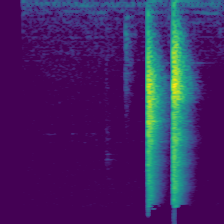

torch.Size([1, 224, 224])


In [123]:
config = AudioTransformConfig()
config.remove_silence = True
config.silence_threshold = 5
config.silence_padding = 1000
config.sg_cfg.f_max = 44100//2
# config.segment_size = 2000
# config.max_segments = 2
# config.window_size = 2000

# For 224x224 nmels = 224, hop 395
# For 128x127 hop 694
config.sg_cfg.n_mels = 224
config.sg_cfg.n_fft = 224*12
config.sg_cfg.hop = 395
config.to_db_scale = True
config.top_db = 76
config.max_to_pad = 2000
items = ItemList.from_csv(valid_path, '../train_curated.csv').split_none().label_from_df(cols='labels', label_delim=',')
carr = []
arr = []

# Get one from each class
for i in range(len(items.x)):
    if not str(items.y[i]) in carr:
        carr.append(str(items.y[i]))
        arr.append(items.x[i])

        
print(len(arr))
# DODGY: TAP (21) Church Bell(37)  Clapping (88)

def preview_tfms(idx):
    print("Class:", carr[idx])
    prevs = preview_transforms(arr[idx], valid_path, config)
    for i,y in prevs: i.show(); print(i.data.shape)
        
preview_tfms(88)

In [ ]:
valid = AudioList.from_csv(valid_path, '../train_curated.csv', config=config).split_by_rand_pct(.2, seed=2).label_from_df(cols='labels', label_delim=',')

tfms = get_spectro_transforms(roll=True, num_rows=10, num_cols=10, tmasks=2, max_shift_pct=.1)
db = valid.transform(tfms).databunch(bs=64)
len(valid.y.classes)

In [125]:
notmulti = [i for i,x in enumerate(valid.train) if len(x[1].obj)<2]
notmulti = valid.train[notmulti]

In [104]:
??torchaudio.save

In [ ]:
i = 0
while i < 1000: 
    d1 = notmulti[random.randint(0,len(notmulti))]
    d2 = notmulti[random.randint(0,len(notmulti))]
    mark = config.cache_dir / ("c_"+md5(str(d1[0].path)+str(d2[0].path))+'.wav')
    d1[0].sig += d2[0].sig
    d1[1].obj += d2[1].obj
    d1[1].data += d2[1].data
    d1[1].raw += d2[1].raw
    d1[0].hear()
    d1[0].path = mark
    torchaudio.save(str(mark), d1[0].sig[None,:], d1[0].sr)
